In [122]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [123]:
# Step 0: Load the proper csvs

xtrain = pd.read_csv("X_train.csv")
xtrain = xtrain.iloc[:, 1:]
xtest = pd.read_csv("X_test.csv")
xtest = xtest.iloc[:, 1:]
ytrain = pd.read_csv("Y_train.csv")

In [124]:
# Step 1: Treat missing values
# Treat missing values as column medians. Important (apparently) to use the medians from the training set in the test set

xtrain = xtrain.fillna(xtrain.median())
xtest = xtest.fillna(xtrain.median())

In [125]:
# Step 2: Scale the training and test data

scaler = preprocessing.StandardScaler()

xtrain_scaled = scaler.fit_transform(xtrain)
xtrain = pd.DataFrame(xtrain_scaled, columns = xtrain.columns)
xtest_scaled = scaler.fit_transform(xtest)
xtest = pd.DataFrame(xtest_scaled, columns = xtest.columns)

In [126]:
# Step 3: Remove unnecessary id column from ytrain that just ***** things up

ytrain1 = ytrain.loc[:, "y"]
ytrain2 = pd.DataFrame(data = ytrain1.values, columns= ['y'])
ytrain = ytrain2

In [127]:
# Step 4: Select top K columns using LassoCV

# Fit Lasso model on the data
from sklearn import linear_model
#reg = linear_model.LassoCV(n_alphas=10)
reg = linear_model.Lasso(alpha=0.3)
reg.fit(xtrain, ytrain)  
#reg.predict(xtest)

# Select top K features from Lasso
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(reg, prefit=True)
xtrain_lasso = model.transform(xtrain)

features = (reg.coef_ != 0)
#xtest_lasso = model.transform(xtest)
xtest_lasso = xtest.loc[:, features]
print((xtrain.shape, xtrain_lasso.shape))


((1212, 832), (1212, 94))


In [128]:


# Do weird Andreas PCA thing

from sklearn import decomposition
import matplotlib.pyplot as plt
pca = decomposition.PCA(n_components=2)
principal_components = pca.fit_transform(xtrain_lasso)
xpca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
# Do weird Andreas PCA thing

from sklearn import decomposition
import matplotlib.pyplot as plt
pca = decomposition.PCA(n_components=2)
principal_components = pca.fit_transform(xtrain_lasso)
xpca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

outliers = (xpca['PC1'] <= 9) & (xpca['PC1'] >= -8) & (xpca['PC2'] <= 7) & (xpca['PC2'] >= -7)
print(np.count_nonzero(outliers))
xtrain_without_outliers = xtrain_lasso[outliers]
ytrain_without_outliers = ytrain[outliers]
xtrain_inliers = xtrain_without_outliers
ytrain_inliers = ytrain_without_outliers



"\n\n# Do weird Andreas PCA thing\n\nfrom sklearn import decomposition\nimport matplotlib.pyplot as plt\npca = decomposition.PCA(n_components=2)\nprincipal_components = pca.fit_transform(xtrain_lasso)\nxpca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])\n# Do weird Andreas PCA thing\n\nfrom sklearn import decomposition\nimport matplotlib.pyplot as plt\npca = decomposition.PCA(n_components=2)\nprincipal_components = pca.fit_transform(xtrain_lasso)\nxpca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])\n\noutliers = (xpca['PC1'] <= 9) & (xpca['PC1'] >= -8) & (xpca['PC2'] <= 7) & (xpca['PC2'] >= -7)\nprint(np.count_nonzero(outliers))\nxtrain_without_outliers = xtrain_lasso[outliers]\nytrain_without_outliers = ytrain[outliers]\nxtrain_inliers = xtrain_without_outliers\nytrain_inliers = ytrain_without_outliers\n\n"

In [143]:
#attempt with isaolation forest for outlier detection
xtrain_lasso = pd.DataFrame(xtrain_lasso)
to_model_columns = xtrain_lasso.columns
clf = IsolationForest(n_estimators=500, max_samples='auto', contamination=float(.12), \
                        max_features=0.2, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(xtrain_lasso[to_model_columns])

pred = clf.predict(xtrain_lasso[to_model_columns])
xtrain_lasso['anomaly'] = pred
xtrain_lasso.drop(xtrain_lasso.columns[-1], axis = 1)
xtrain_lasso.head()

is_not_outlier = xtrain_lasso['anomaly']==1
#print(is_not_outlier)
xtrain_inliers = xtrain_lasso[is_not_outlier].drop('anomaly', axis = 1)
ytrain_inliers = ytrain[is_not_outlier]

In [112]:
'''

def to_be_eliminated(df):
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

    return to_drop

to_be_elim = to_be_eliminated(xtrain_poly)

'''

'\n\ndef to_be_eliminated(df):\n    \n    # Create correlation matrix\n    corr_matrix = df.corr().abs()\n\n    # Select upper triangle of correlation matrix\n    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))\n\n    # Find features with correlation greater than 0.95\n    to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]\n\n    return to_drop\n\nto_be_elim = to_be_eliminated(xtrain_poly)\n\n'

In [145]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
xtrain_poly = poly.fit_transform(xtrain_inliers)

print(xtrain_poly.shape)

# Create polynomial features for xtest
poly = PolynomialFeatures(2)
xtest_poly = poly.fit_transform(xtest_lasso)
print(xtest_poly.shape)

xtrain_poly = pd.DataFrame(xtrain_poly)


(1066, 4560)
(776, 4560)


In [146]:
# Try Lasso to remove some of these
#tune parameter via CV 

# Fit Lasso model on the data
from sklearn import linear_model

k = 5
alphas = np.array([0, 0.01, 0.1, 0.2, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.35, 0.4])

cv_means = []
cv_stds = []
for a in alphas:
    model= linear_model.Lasso(alpha = a, fit_intercept = False, normalize=False)
    scores = cross_val_score(estimator = model,
                             X = xtrain_poly,
                             y = ytrain_inliers,
                             scoring = 'r2',
                             cv = k)
    cv_means.append(np.mean(scores))
    cv_stds.append(np.std(scores))

<ErrorbarContainer object of 3 artists>

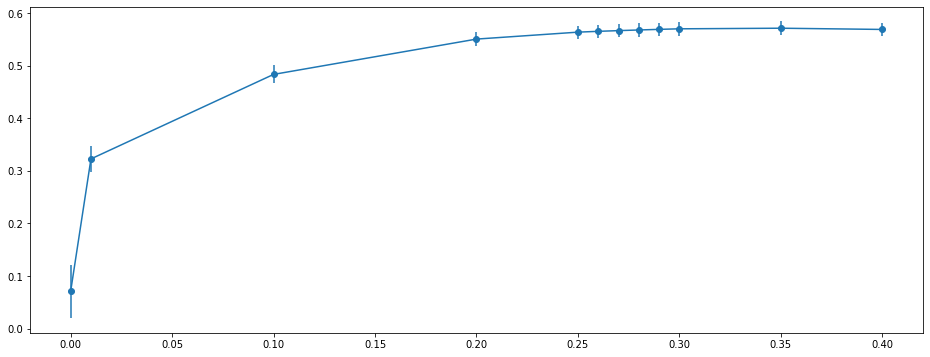

In [116]:
fig, ax = plt.subplots(figsize=(16,6))
ax.errorbar(x = alphas, y = cv_means, yerr = np.array(cv_stds)/math.sqrt(10), fmt='-o')

ATTEMPT 1: REMOVE POLYNOMIAL FEATURES WITH LASSO 

In [147]:
# Fit Lasso model on the data
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.3)
reg.fit(xtrain_poly, ytrain_inliers)  

# Select top K features from Lasso
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(reg, prefit=True)
xtrain_lasso_2 = model.transform(xtrain_poly)
print((xtrain.shape, xtrain_lasso_2.shape))

# Select top K features from xtest
features = (reg.coef_ != 0)
xtest_lasso_2 = pd.DataFrame(xtest_poly).iloc[:, features]
print((xtrain.shape, xtrain_lasso_2.shape))
print((xtest.shape, xtest_lasso_2.shape))


((1212, 832), (1066, 214))
((1212, 832), (1066, 214))
((776, 832), (776, 214))


In [148]:
# Step 7: Ridge Regression on this new xtrain

# Ridge regression on this new xtrain
# Try Lasso to remove some of these
#tune parameter via CV 

# Step 7: Ridge Regression on this new xtrain

# Ridge regression on this new xtrain
#reg2 = linear_model.RidgeCV(alphas=(0.1, 0.25, 0.5, 1.0, 3.0, 10.0, 20.0))
#reg2 = linear_model.LassoCV(cv=10, n_alphas=20)
#reg2.fit(xtrain_lasso_2, ytrain_inliers)

reg2 = linear_model.Lasso(alpha=0.3)

# Check cross-val score
from sklearn.model_selection import cross_val_score
scores = cross_val_score(reg2, xtrain_lasso_2, ytrain_inliers, cv=30, scoring='r2')
print(np.mean(scores))

0.4260390419873276


In [149]:
reg2.fit(xtrain_lasso_2, ytrain_inliers)
predict = reg2.predict(X = xtest_lasso_2)
index = pd.read_csv("sample.csv")
index['y'] = predict

index.to_csv("trial.csv")

In [121]:
min(predict)

41.07781748751473

AttributeError: 'list' object has no attribute 'size'